In [2]:
from strace_miner.core.strace_line_reader import StraceLineReader
from strace_miner.core.strace_analyzer import StraceAnalyzer
from strace_miner.core.preprocessor import Preprocessor
from strace_miner.views.v2.io_line_reader import IOLineReaderV2

In [4]:
%%bash
strace -f -tt -T -r -yy -o  logs/view3.st python src/mmarrays.py 100000

Data size = 819.200 MB
Chunk size = 0.800 MB


In [5]:
!cat logs/view3.st

90126 18:15:23.112554 (+     0.000000) execve("/opt/conda/envs/hdf5-tutorial/bin/python", ["python", "src/mmarrays.py", "100000"], 0x7ffd057444e8 /* 59 vars */) = 0 <0.000288>
90126 18:15:23.113233 (+     0.000611) brk(NULL) = 0x562520074000 <0.000132>
90126 18:15:23.113543 (+     0.000307) readlink("/proc/self/exe", "/opt/conda/envs/hdf5-tutorial/bi"..., 4096) = 44 <0.000072>
90126 18:15:23.113792 (+     0.000246) access("/etc/ld.so.preload", R_OK) = -1 ENOENT (No such file or directory) <0.000086>
90126 18:15:23.114072 (+     0.000280) openat(AT_FDCWD, "/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/x86_64/libpthread.so.0", O_RDONLY|O_CLOEXEC) = -1 ENOENT (No such file or directory) <0.000085>
90126 18:15:23.114353 (+     0.000279) stat("/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/x86_64", 0x7ffc2480cdf0) = -1 ENOENT (No such file or directory) <0.000072>
90126 18:15:23.114552 (+     0.000201) openat(AT_FDCWD, "/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/libpt

In [6]:
import re

inp_str = 'read(3</etc/locale.alias>,s(),dd) = 0 <1.22>'
#pattern = r'read\((.*?)\)[^)]*$'
pattern = r'<(.*?)>'
match = re.search(pattern, inp_str)
match.group(1)

'/etc/locale.alias'

In [3]:
# %%writefile ../strace_miner/views/v3/io_line_reader.py

# from ...core.strace_line_reader import StraceLineReader

class IOLineReaderV3(IOLineReaderV2):
    def __init__(self,prefixes=None,collapse=False):
        super().__init__()
        self.prefixes = prefixes
        self.collapse = collapse    

    
    def _get_concise_path(self,path,file_name=False):
        components = path.split('/')
        if len(components) < 3:
            pass
        else:
            path = "/{}/{}".format(components[1],components[2])
            if file_name:
                if len(components)>3:
                    path = path + ".../{}".format(components[-1])
        return path
    
    def get_fs(self,call):
        if not call in ['read','write']:
            return ' '
        
        pattern = r'<(.*?)>' 
        val = self.match_pattern(pattern)

        if not self.collapse:
            path = self._get_concise_path(val)
        else:
            path = " "
        if self.prefixes:
            for prefix in self.prefixes:
                if prefix in val:
                    path = self._get_concise_path(val,file_name=True)
        return path                    


    def parse_call_attrs(self,call,unfinished,resumed,error=False):
        if error or call not in ['read','write']:
            if not unfinished:
                return ['0', ' ']
            else:
                return [None,None]
            
        bytes = self.get_bytes(call,unfinished,resumed)
        if not resumed:
            fs = self.get_fs(call)
        else:
            fs = None
        return [bytes,fs]

In [7]:
lr = IOLineReaderV3(collapse=False)
line = '2343 09:55:36.270878 (+     0.002224) read(3</workspaces/hdf5-tutorial/libs/strace_miner/dev/src/mmarrays.py>, "t(CHUNK_SIZE*8*1e-6))", 4096) = 22 <0.000190>'
lr.process_line(line)

[2343,
 'read',
 '09:55:36.270878',
 0.00019,
 '[<4MB]',
 '/workspaces/hdf5-tutorial']

In [17]:
# %%writefile ../strace_miner/views/v3/io_miner_v3.py
# from ...core.strace_analyzer import StraceAnalyzer
# from ...core.preprocessor import Preprocessor

import os
import pm4py
import pandas as pd


class IOMinerV3(StraceAnalyzer):
    def __init__(self,st_log_paths,io_calls,line_reader):
        super().__init__(st_log_paths)
        self.io_calls = io_calls
        self.line_reader = line_reader
        self.activities_summary = {}

    
    def preprocess(self, reuse=False):
        for st_path in self.st_log_paths: 
              st = Preprocessor(st_path,self.io_calls,self.line_reader,'IO')
              st.extra = ['bytes','fs']
              case_id = os.path.basename(st_path).split('.st')[0]
              if not reuse:
                st.prepare_csv_log()
            
              self.st_logs[case_id] = st
    
    def _get_activities_summaries(self,df,st):
          ## find the total duration of each activity
          summary = []
          grouped = df.groupby('concept')
          sum_by_call = dict(grouped['duration'].sum())      
          for call,dur in sum_by_call.items():
               p_tot = (dur/st.total_time)*100.0     
               summary.append([call.split('\n'),dur,p_tot])
          return pd.DataFrame(summary,columns=st.stat_cols)
    
    def prepare_summaries_and_event_log(self):
         df_all = []
         for case_id,st in self.st_logs.items():
              df = st.get_df_from_csv()
              summary, df = st.process(df)
              self.summaries[case_id] = summary
              df['case'] = case_id
              df['concept'] = df['call'] + '\n' + df['bytes'].astype(str) + '\n' + df['fs']
              self.activities_summary[case_id] = self._get_activities_summaries(df,st)

              df = pm4py.format_dataframe(df,case_id='case',activity_key='concept',timestamp_key='time')
              df_all.append(df)

         self.el = pm4py.convert_to_event_log(pd.concat(df_all,ignore_index=True))


    def prepare_dfg(self):
         self.dfg,self.dfg_im,self.dfg_fm = pm4py.discover_dfg(self.el)

    def view_dfg(self):
         if self.dfg:
              return pm4py.view_dfg(self.dfg,self.dfg_im,self.dfg_fm)

In [56]:
#LOG_FILE =  "logs/mmarrays.st"
#LOG_FILE =  "logs/multi_threaded.st"
LOG_FILE = "logs/view3.st"

In [57]:
io_calls = ['read','write']
line_reader = IOLineReaderV3(['/workspaces'],collapse=False)
sta = IOMinerV3([LOG_FILE,],io_calls,line_reader)

In [58]:
sta.preprocess()

CSV log path: logs/view3.csv


In [59]:
sta.prepare_summaries_and_event_log()
sta.prepare_dfg()

/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [60]:
sta.activities_summary[list(sta.activities_summary.keys())[0]]

,call,duration,percent
0,"[read, [<4KB], /dev/urandom<char 1:9]",0.000162,0.004930
1,"[read, [<4KB], /home/vscode]",0.000031,0.000943
2,"[read, [<4KB], /lib/x86_64-linux-gnu]",0.000328,0.009982
3,"[read, [<4KB], /opt/conda]",0.042362,1.289192
4,"[read, [<4KB], /workspaces/hdf5-tutorial.../mm...",0.000066,0.002009
5,"[read, [<4MB], /etc/locale.alias]",0.000106,0.003226
6,"[read, [<4MB], /home/vscode]",0.000061,0.001856
7,"[read, [<4MB], /opt/conda]",0.029101,0.885623
8,"[read, [<4MB], /proc/stat]",0.000173,0.005265
9,"[read, [<4MB], /usr/share]",0.000168,0.005113


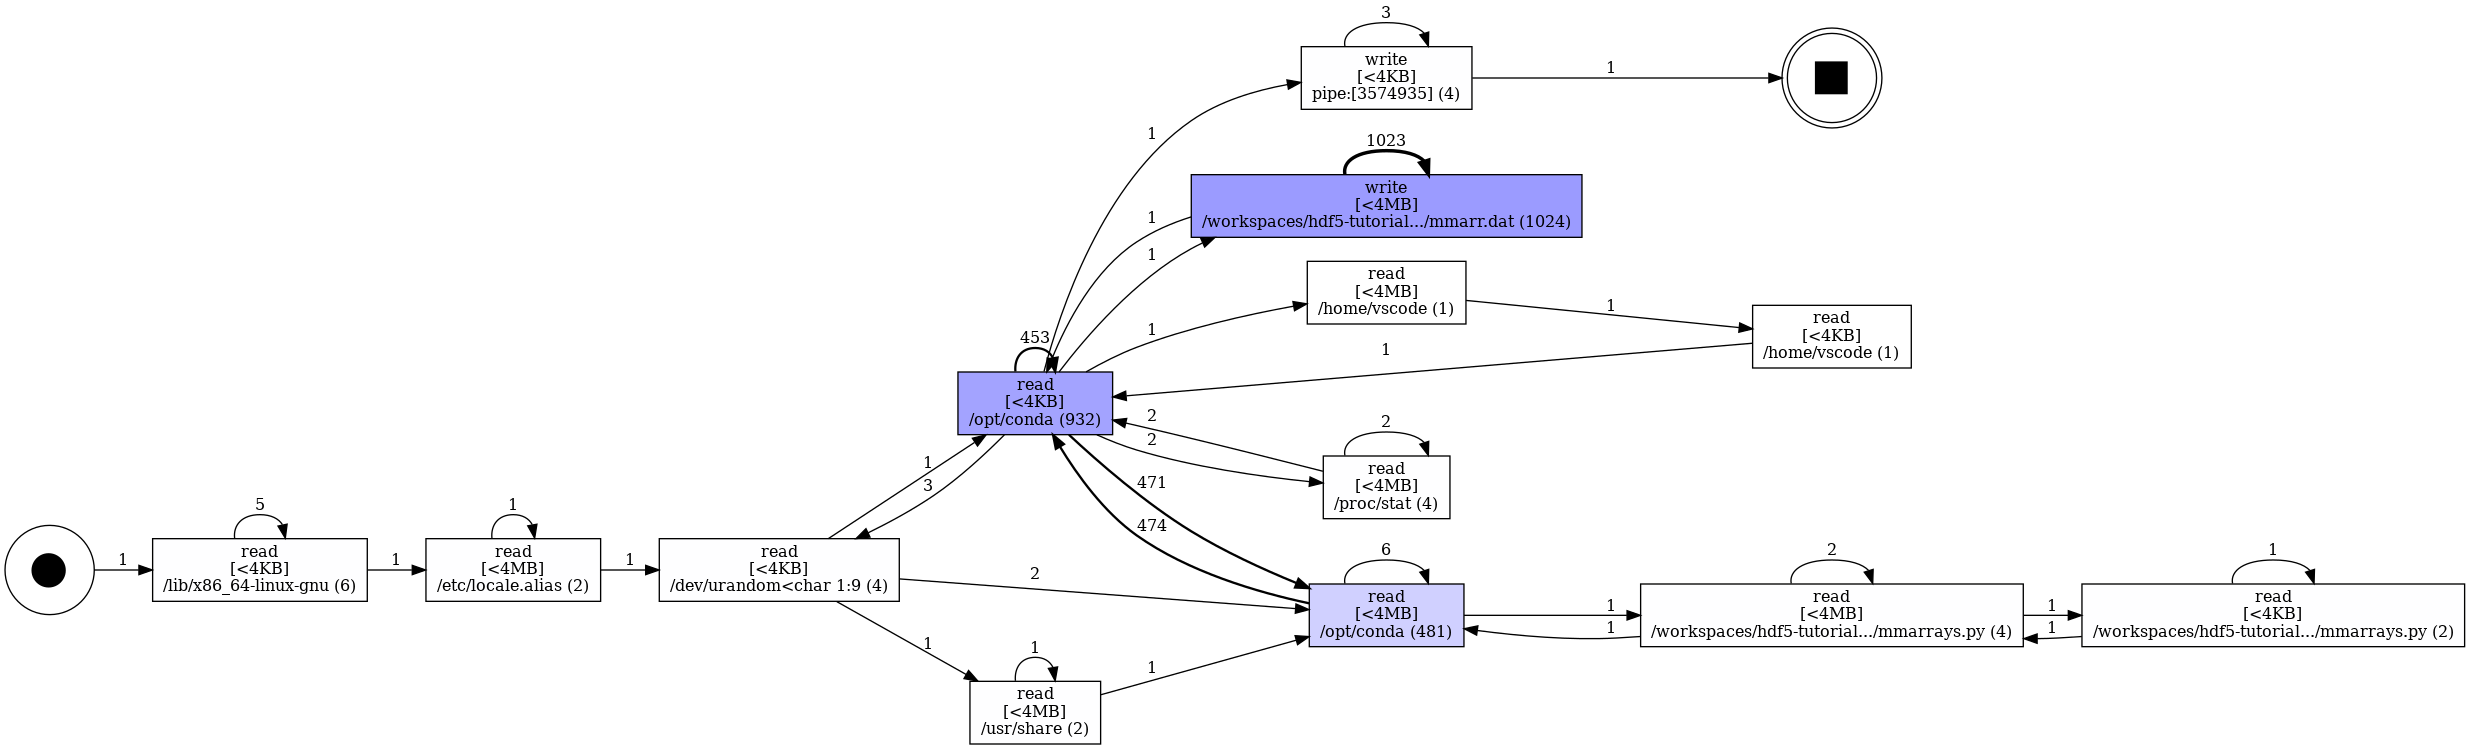

In [61]:
sta.view_dfg()